# Librairies

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.linear_model import ElasticNet, TweedieRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, cross_validate,GridSearchCV,RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
import lightgbm as lgbm
#conda install -c conda-forge xgboost
#conda install -c anaconda lightgbm
#import r-catboost as cboost
from google.colab import drive
from google.colab import files
from functools import partial

# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
#!pip install catboost
from catboost import CatBoost, CatBoostRegressor, CatBoostClassifier
#!pip install optuna
import optuna

# Data

In [ ]:
# if on gg colab
train = files.upload()
test = files.upload()
sample_submission = files.upload()

Saving train.csv to train.csv


Saving test.csv to test.csv


Saving sample_submission.csv to sample_submission.csv


In [ ]:
# Read the data
sample_submission=pd.read_csv('sample_submission.csv',index_col='id')
train = pd.read_csv('train.csv', index_col='id')
test = pd.read_csv('test.csv', index_col='id')
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15289 entries, 0 to 15288
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   clonesize             15289 non-null  float64
 1   honeybee              15289 non-null  float64
 2   bumbles               15289 non-null  float64
 3   andrena               15289 non-null  float64
 4   osmia                 15289 non-null  float64
 5   MaxOfUpperTRange      15289 non-null  float64
 6   MinOfUpperTRange      15289 non-null  float64
 7   AverageOfUpperTRange  15289 non-null  float64
 8   MaxOfLowerTRange      15289 non-null  float64
 9   MinOfLowerTRange      15289 non-null  float64
 10  AverageOfLowerTRange  15289 non-null  float64
 11  RainingDays           15289 non-null  float64
 12  AverageRainingDays    15289 non-null  float64
 13  fruitset              15289 non-null  float64
 14  fruitmass             15289 non-null  float64
 15  seeds              

No missing data

# EDA

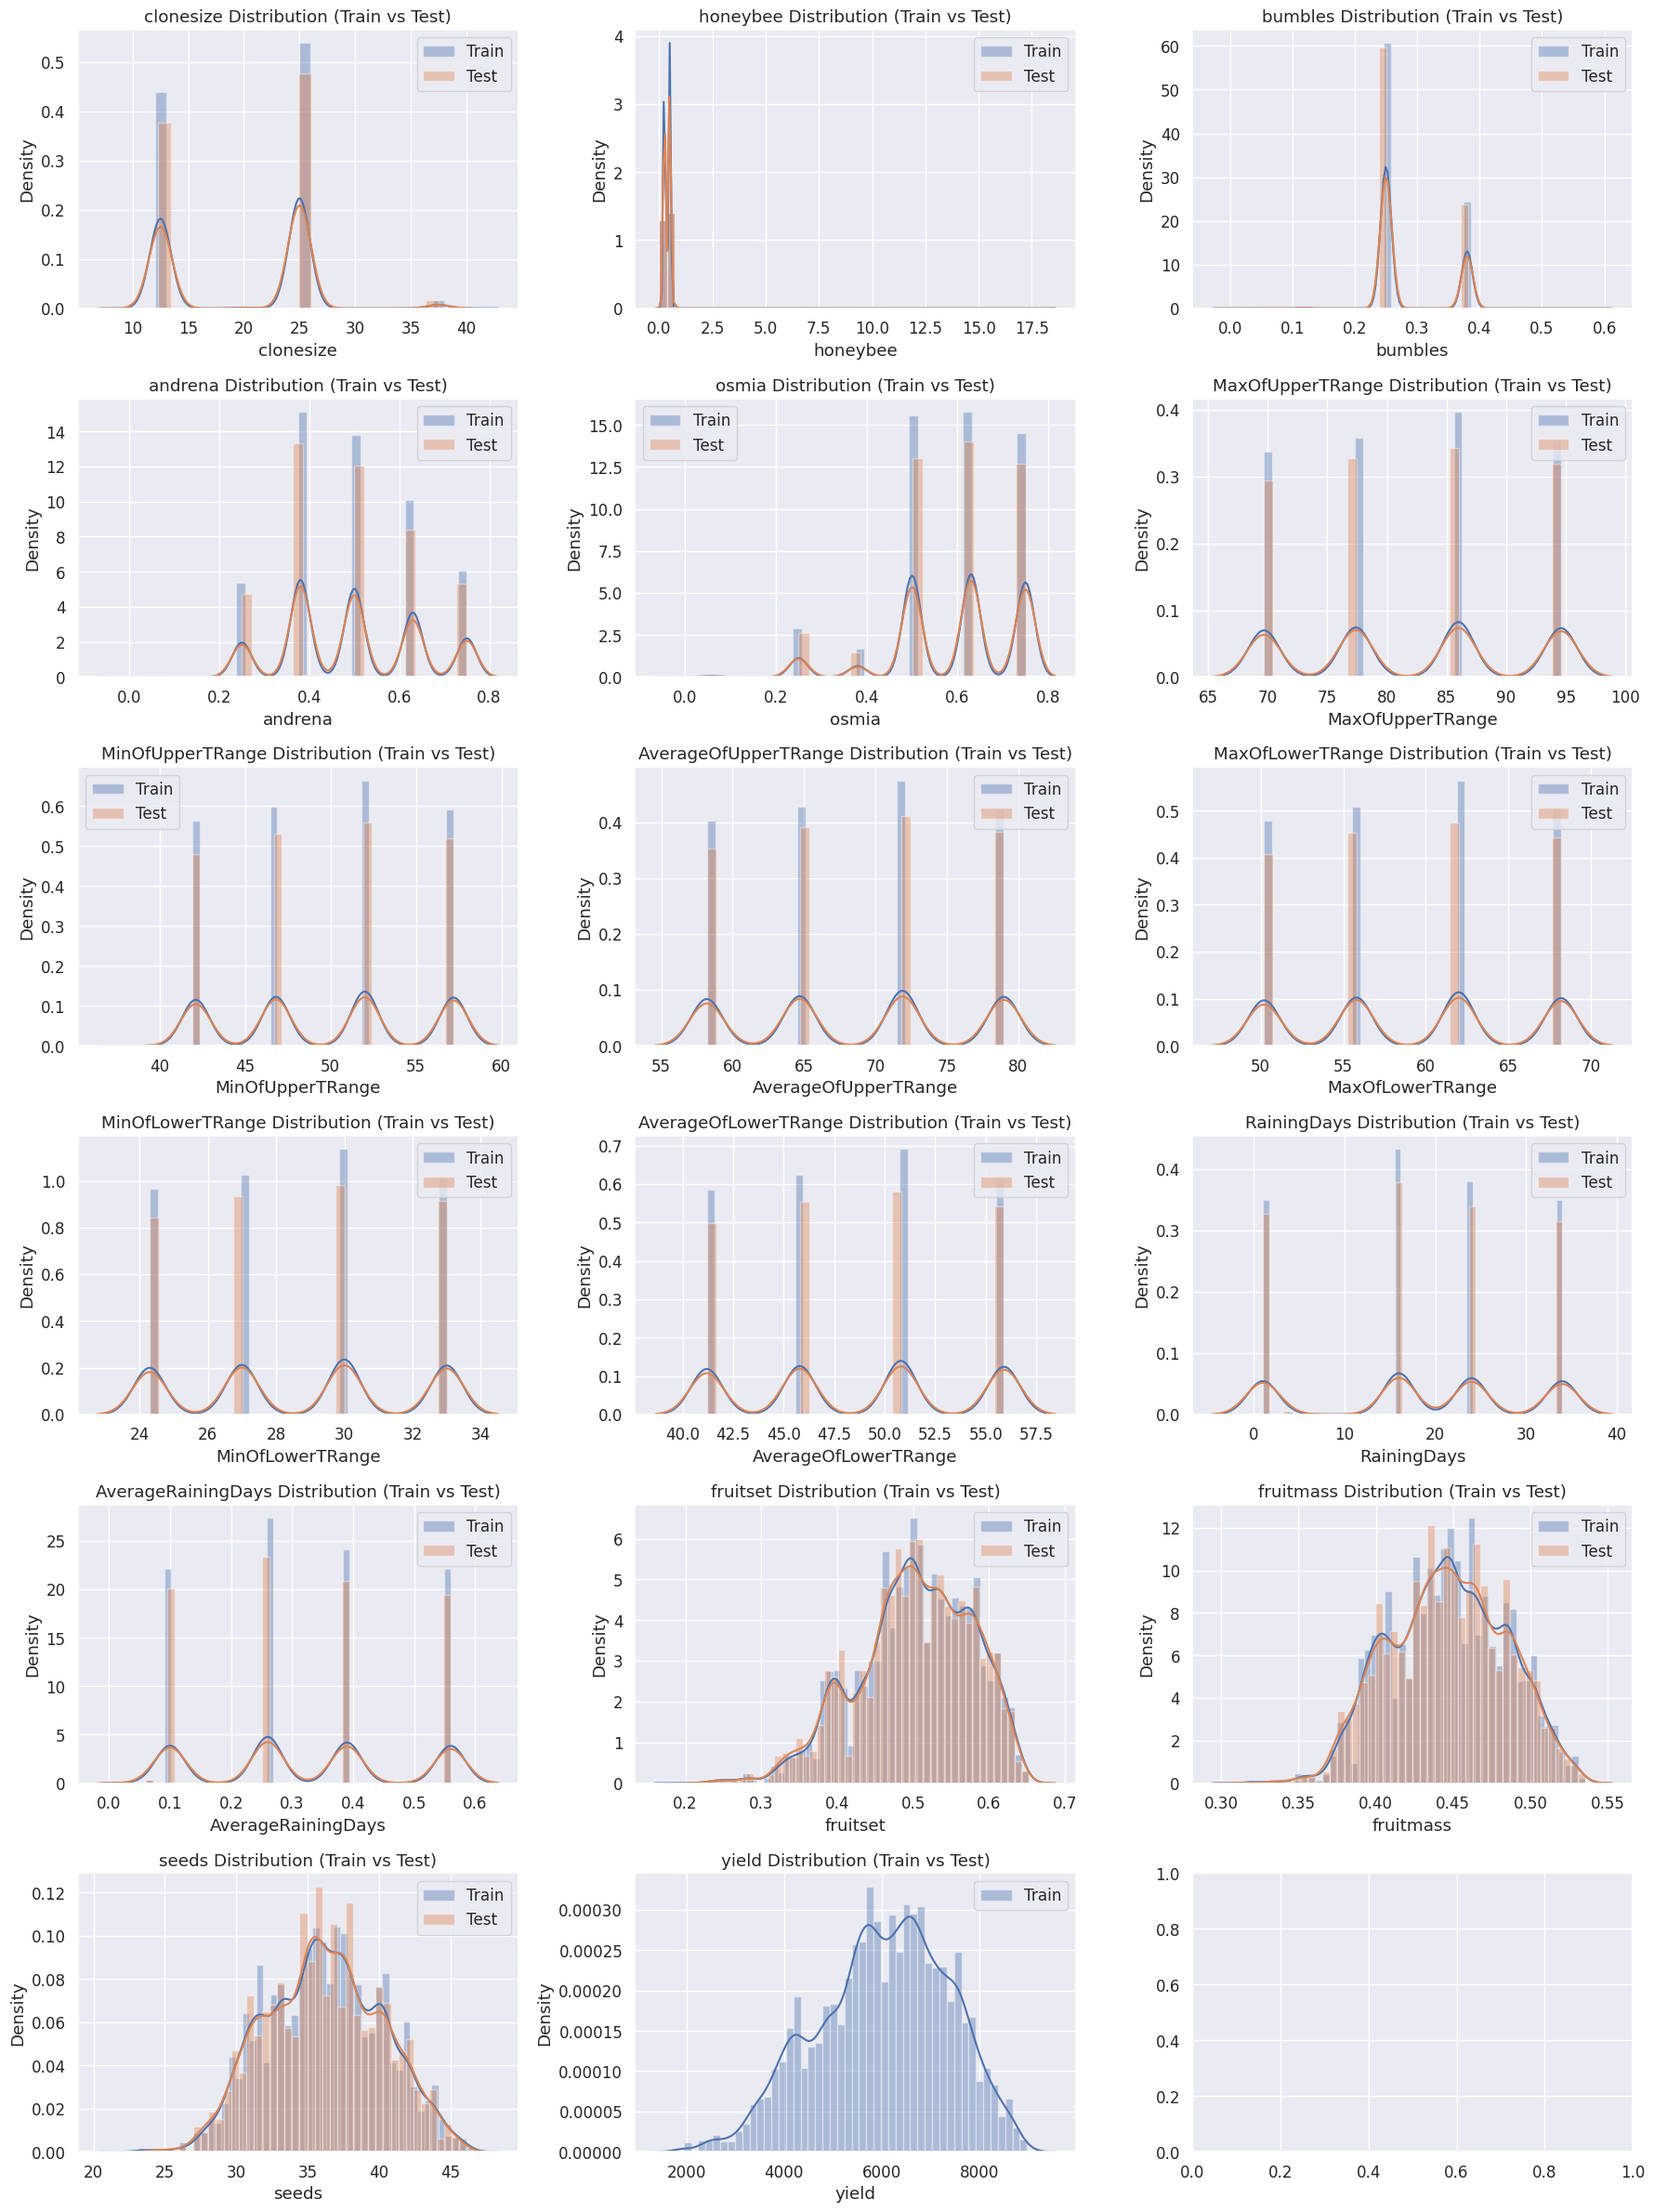

In [ ]:
def plot_histograms(df_train, df_test, target_col, n_cols=3):
    n_cols = 3
    n_rows = (len(df_train.columns) - 1) // n_cols + 1

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 4*n_rows))
    axes = axes.flatten()

    for i, var_name in enumerate(df_train.columns.tolist()):
       # if var_name != 'is_generated':
        ax = axes[i]
        sns.distplot(df_train[var_name], kde=True, ax=ax, label='Train')
        if var_name != target_col:
            sns.distplot(df_test[var_name], kde=True, ax=ax, label='Test')
        # sns.distplot(original[var_name], kde=True, ax=ax, label='Original')
        ax.set_title(f'{var_name} Distribution (Train vs Test)')
        ax.legend()

    plt.tight_layout()
    plt.show()

plot_histograms(train, test, target_col='yield', n_cols=3)

All these features are discrete with low cardinality: \\
['clonesize', 'honeybee', 'bumbles', 'andrena', 'osmia',
       'MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange',
       'MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageOfLowerTRange',
       'RainingDays', 'AverageRainingDays'] \\
We might convert them into categorical features!

In [ ]:
#discret_feature = ['clonesize', 'honeybee', 'bumbles', 'andrena', 'osmia', 'MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange', 'MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageOfLowerTRange', 'RainingDays', 'AverageRainingDays']

#for feature in discret_feature:
#  values = sorted(train[feature].unique())
 # print(values, feature)
 # bins = [-np.inf]
 # for i in range(len(values)-1):
 #   bins.append(str((values[i] + values[i+1]) / 2))
 # bins.append(np.inf)
 # labels = [str(i) for i in values]
 # train[f'{feature}_bins'] = pd.cut(train[feature], bins = bins, labels = labels)
#cat_feature = [f'{i}_bins' for i in discret_feature]

#all_feature = train.columns
#numerical_feature = all_feature.drop(discret_feature)
#numerical_feature = numerical_feature.drop(cat_feature)


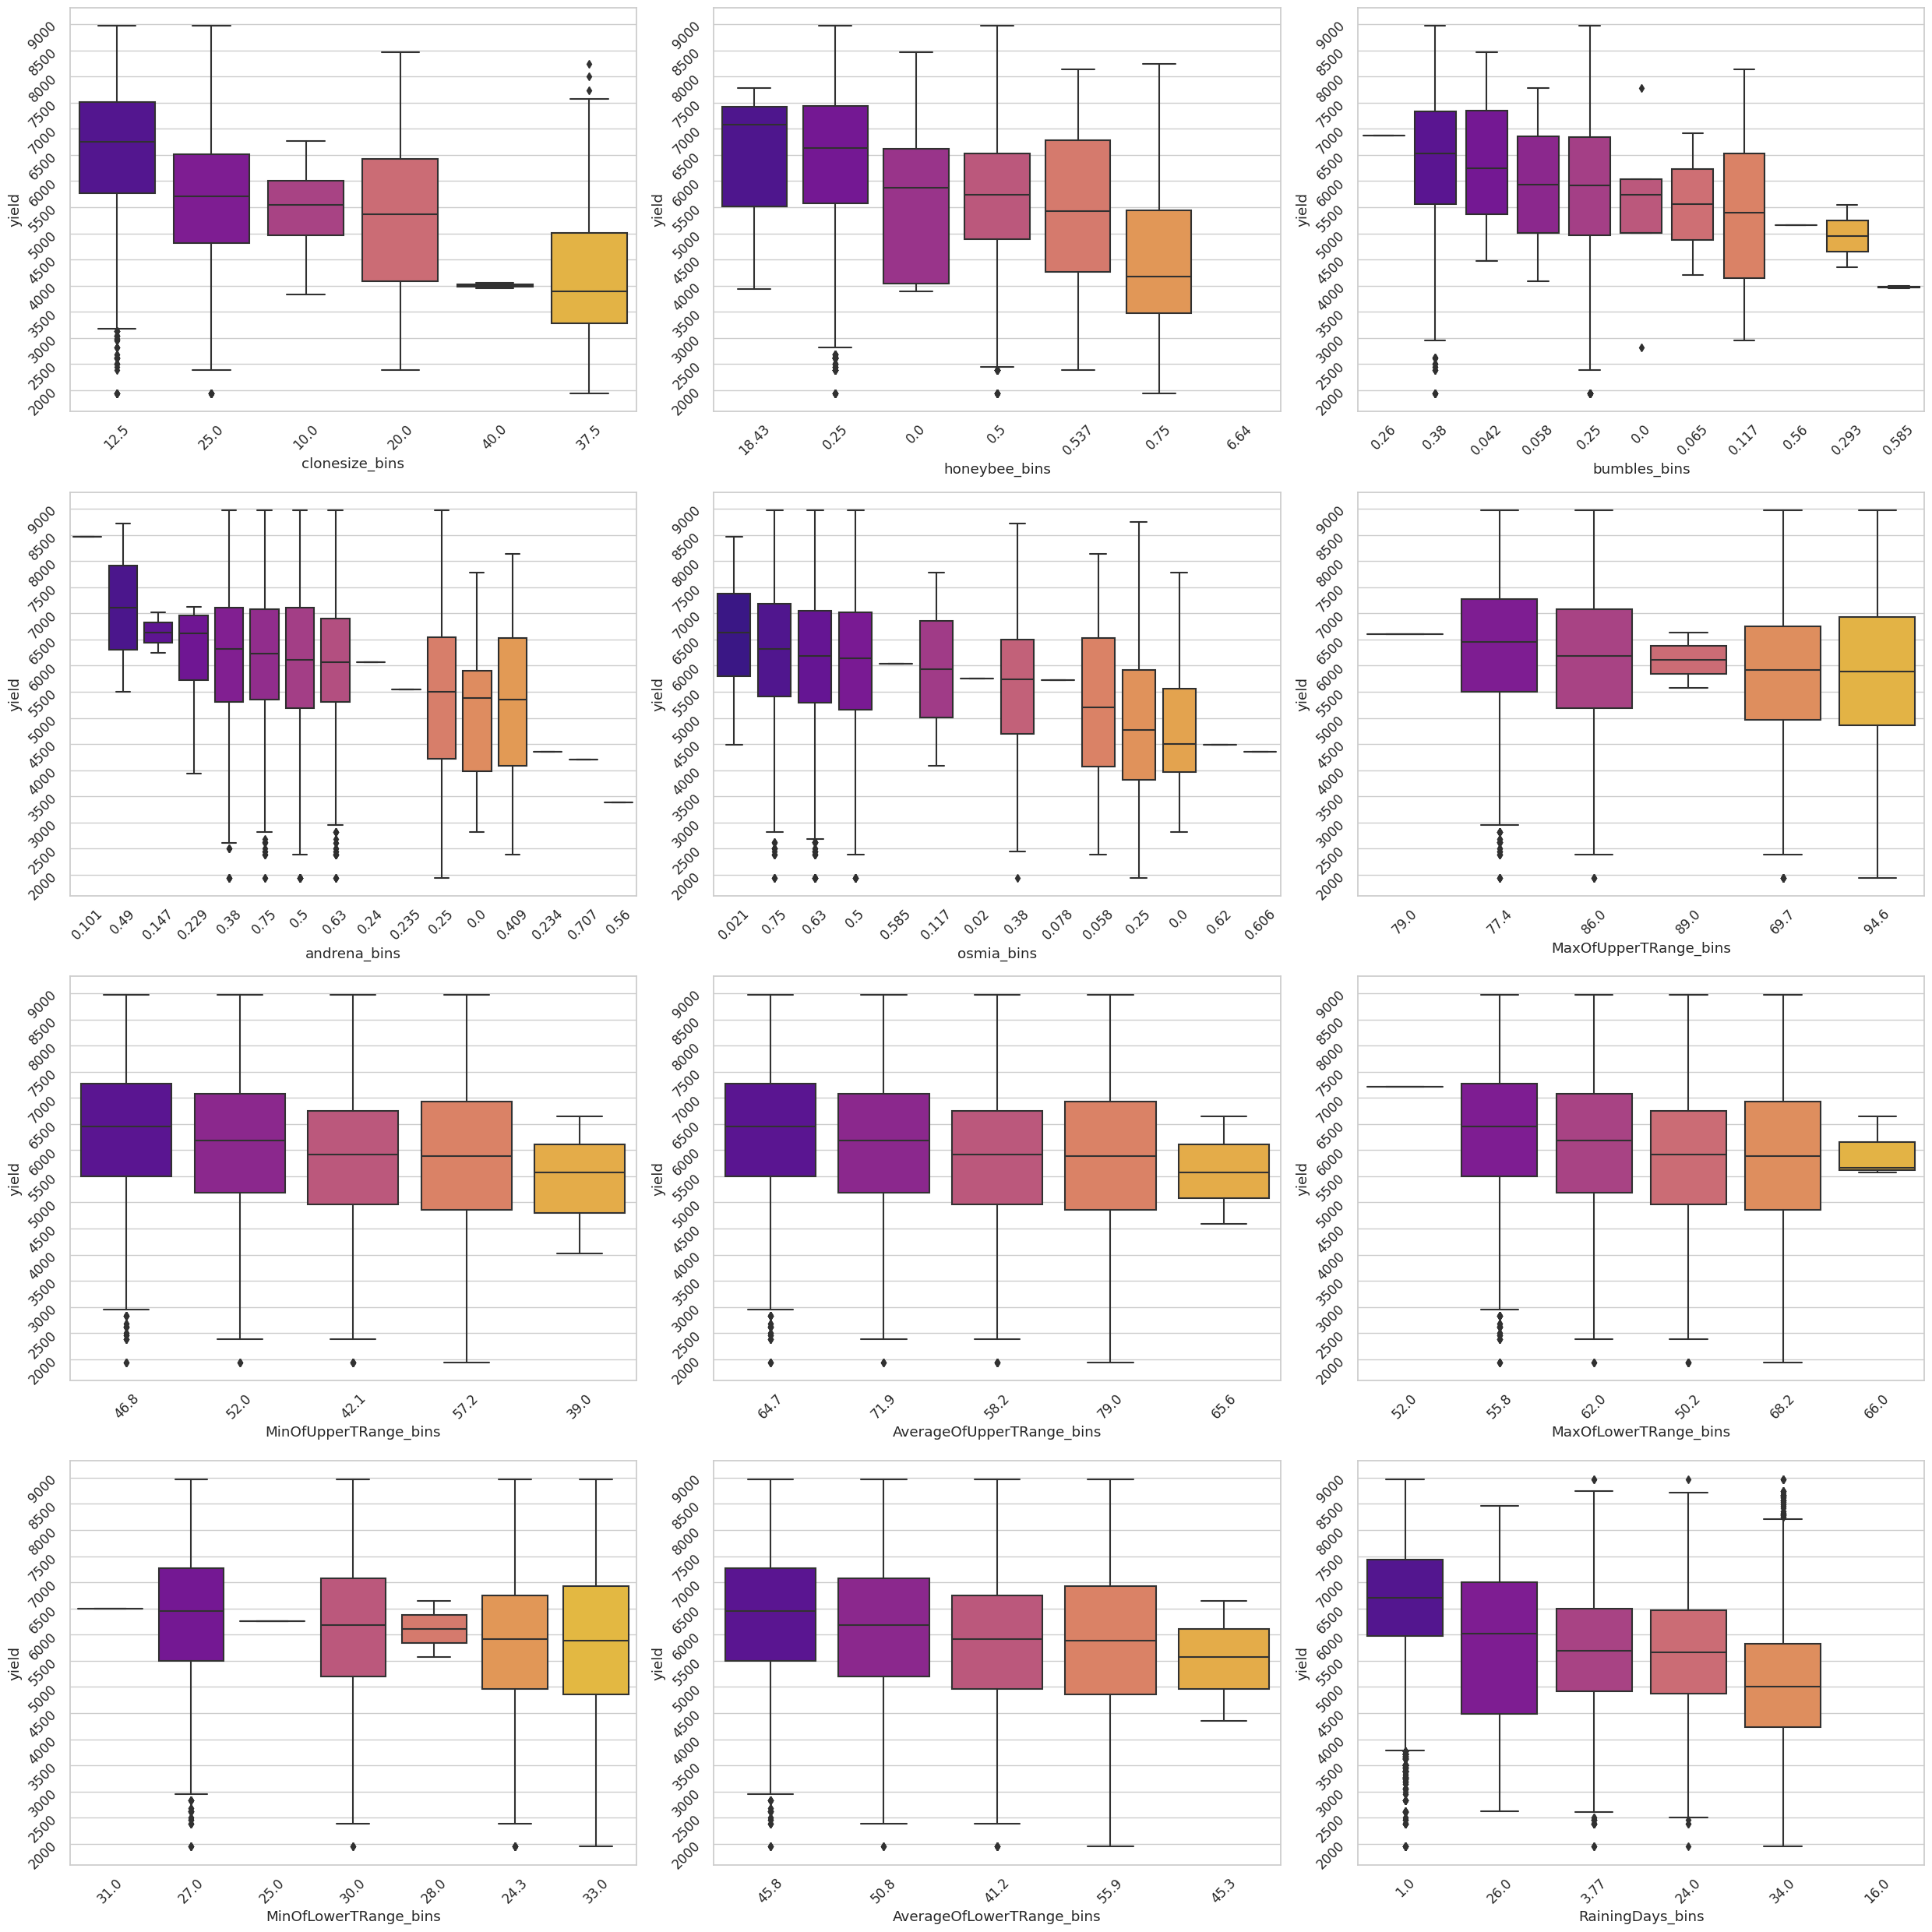

In [ ]:
def srt_box(y, df):

    '''A function for displaying categorical variables.'''

    fig, axes = plt.subplots(4, 3, figsize=(25, 25))
    axes = axes.flatten()

    for i, j in zip(df.columns, axes):

        sortd = df.groupby([i])[y].median().sort_values(ascending=False)
        sns.boxplot(x=i,
                    y=y,
                    data=df,
                    palette='plasma',
                    order=sortd.index,
                    ax=j)
        j.tick_params(labelrotation=45)
        j.yaxis.set_major_locator(MaxNLocator(nbins=18))

        plt.tight_layout()

#srt_box('yield', train[cat_feature])

Past boxplot when transforming discret features into categorical ones. Didnt used it after so far.

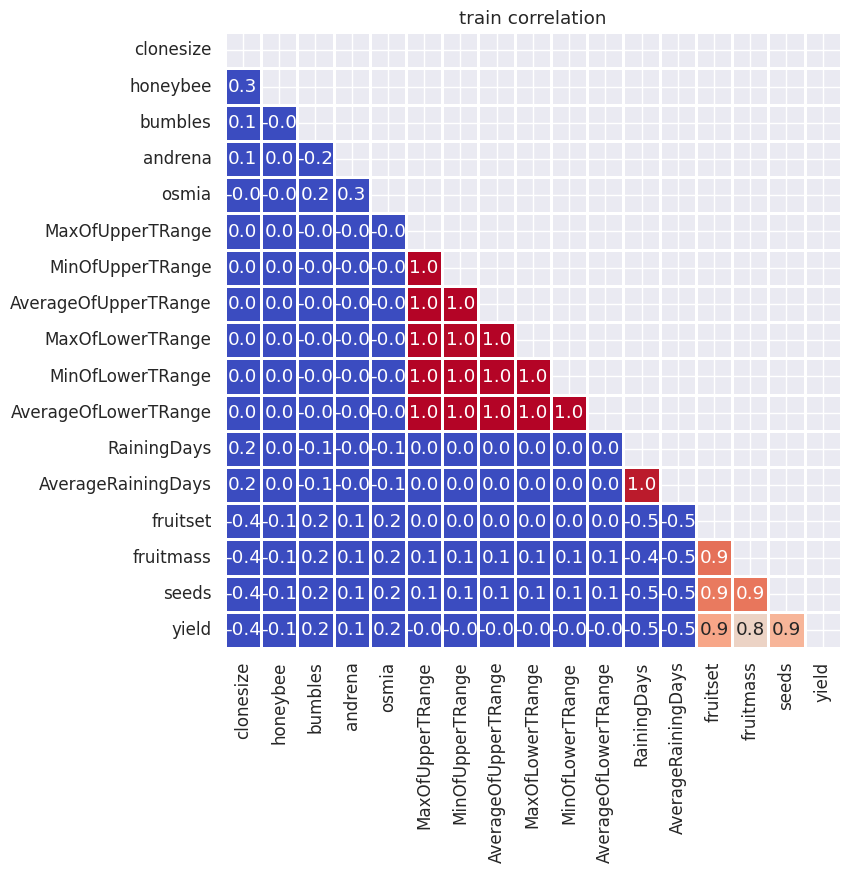

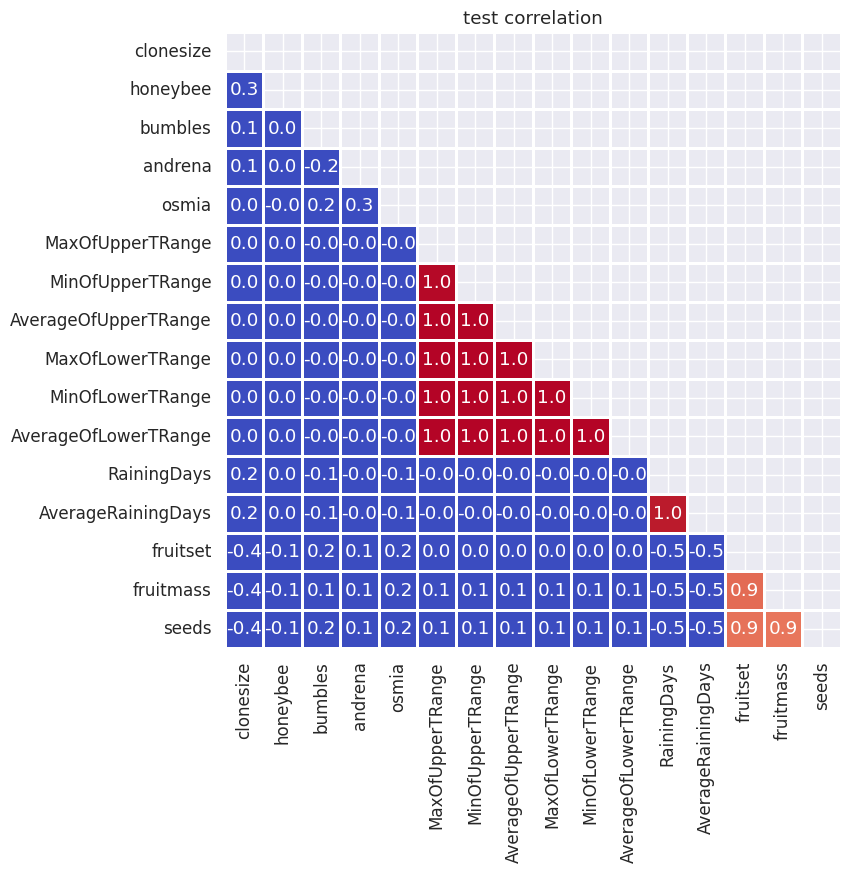

In [ ]:
train.name='train'
test.name='test'
dataset=[train,test]
for data in dataset:
  sns.set(font_scale=1.1)
  correlation = data.corr()
  mask = np.triu(correlation.corr())
  plt.figure(figsize=(8, 8))
  sns.heatmap(correlation,
              annot=True,
              fmt='.1f',
              cmap='coolwarm',
              square=True,
              mask=mask,
              linewidths=1,
              cbar=False,
              vmin=0.6)
  plt.title(data.name+' correlation')
  plt.show()

fruitmass, fruitset and see really correlated. We might get rid of one. \\
After try, kicking fruitst lower performances (correlated but gives information) and not so many features

4


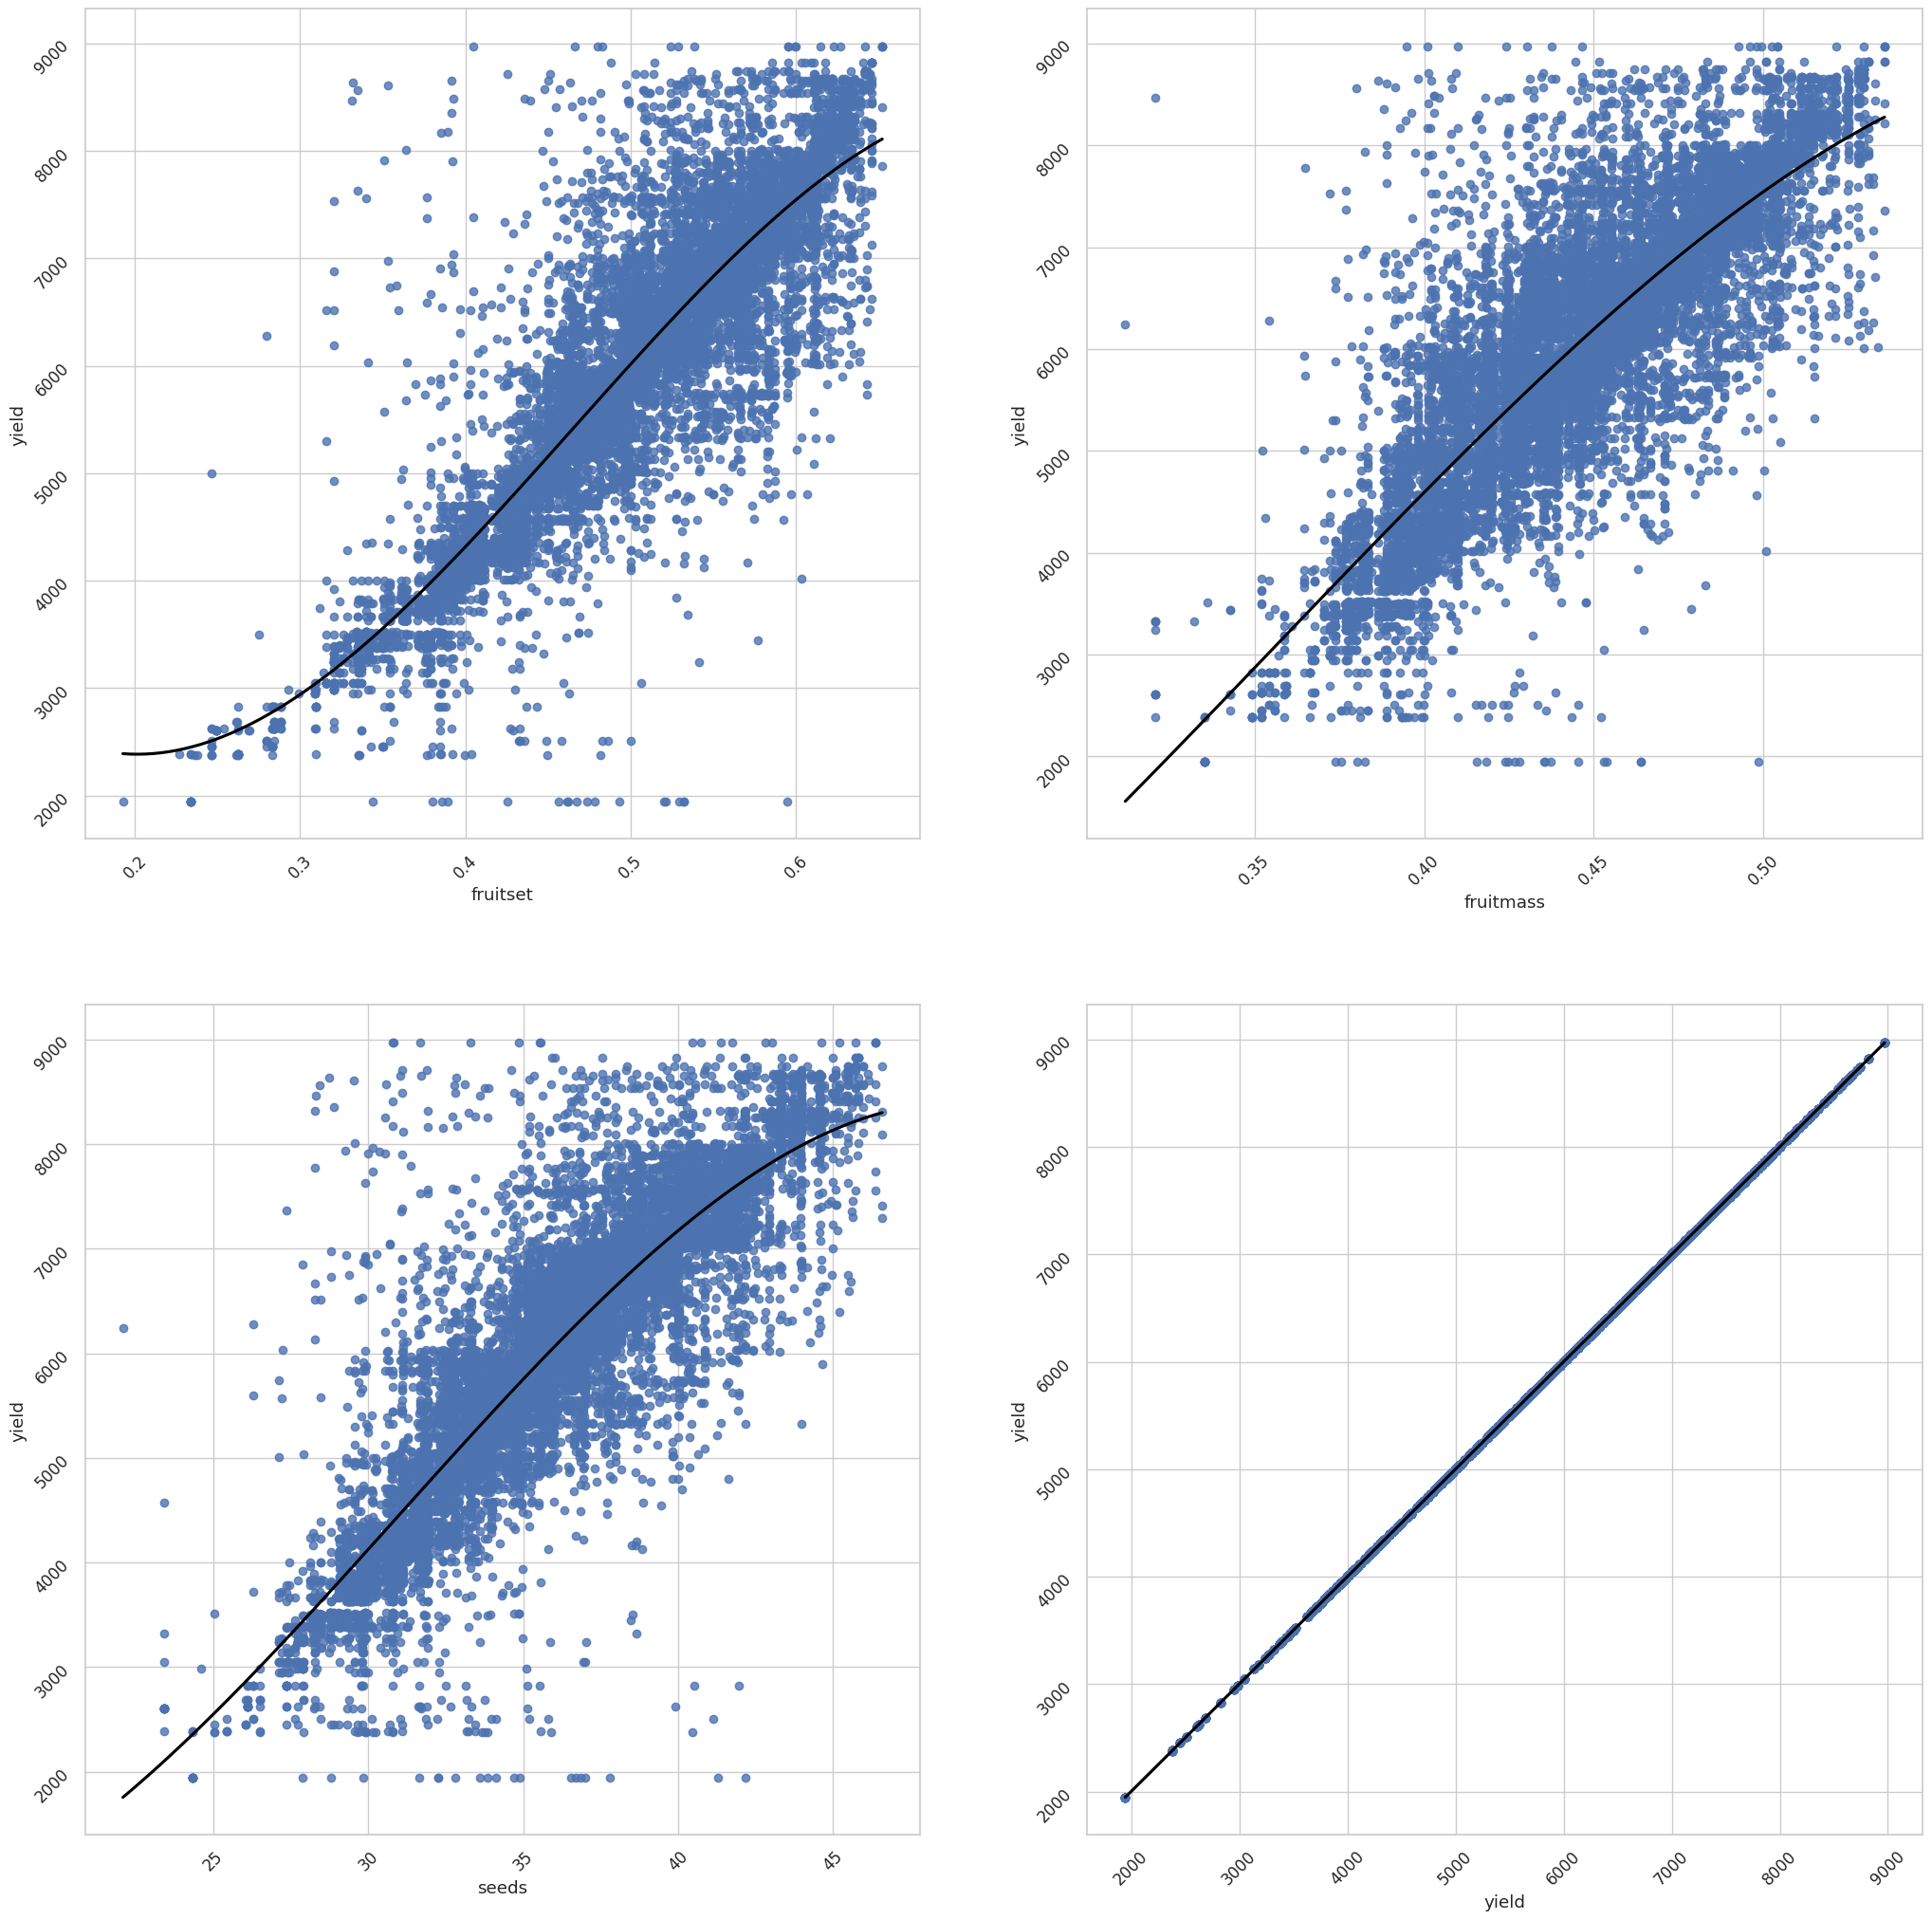

In [ ]:
numerical_feature=['fruitset','fruitmass','seeds']
num_features=numerical_feature# train.select_dtypes(include=['number']).columns
print(len(num_features))
fig, axes = plt.subplots(2, 2, figsize=(25, 25))
axes = axes.flatten()
for feature,axe in zip(num_features,axes):
  #  sns.regplot(train[feature],ax=axe,ci=None,order=3,line_kws={'color': 'black'})
    sns.regplot(x=train[feature],y=train['yield'],ax=axe,ci=None,order=3,line_kws={'color': 'black'})
    #color='#e74c3c',scatter_kws={'alpha':0.4})
    axe.tick_params(labelrotation=45)


# Feature Engineering


In [ ]:
y_train=train[['yield']]
X_train=train.loc[:, train.columns !='yield']
X_test=test

X_train_feat_eng=X_train.copy()
X_test_feat_eng=X_test.copy()


In [ ]:
data = [X_train_feat_eng, X_test_feat_eng]
for X in data:
  X['total_bees'] = X['osmia'] + X['andrena'] + X['honeybee'] + X['bumbles']
  X['fruitmas_per_seed'] = X['fruitmass'] / X['seeds']
  X['fruitset_per_seed'] = X['fruitset'] / X['seeds']
  X['averages_temp'] = abs(X['AverageOfUpperTRange'] - X['AverageOfLowerTRange'])
  X['max_temp'] = X['MaxOfUpperTRange'] + X['MaxOfLowerTRange']
  X['min_temp'] = X['MinOfUpperTRange'] + X['MinOfLowerTRange']
  X['ecart_up'] = X['MaxOfUpperTRange'] - X['MinOfUpperTRange']
  X['ecart_down'] = X['MaxOfLowerTRange'] - X['MinOfLowerTRange']
  X['rain_temps'] = X['AverageRainingDays'] / X['averages_temp']
  X['AverageUpperTemperature'] = (X['MaxOfUpperTRange'] + X['MinOfUpperTRange'] + X['AverageOfUpperTRange'])
  X['AverageLowerTemperature'] = (X['MaxOfLowerTRange'] + X['MinOfLowerTRange'] + X['AverageOfLowerTRange'])

# Models, Blending and optimization

In [ ]:
class Splitter:
    def __init__(self, kfold=True, n_splits=5):
        self.n_splits = n_splits
        self.kfold = kfold

    def split_data(self, X, y, random_state_list):
        if self.kfold:
            for random_state in random_state_list:
                kf = KFold(n_splits=self.n_splits, random_state=random_state, shuffle=True)
                for train_index, val_index in kf.split(X, y):
                    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
                    yield X_train, X_val, y_train, y_val
        else:
            raise ValueError(f"Invalid kfold: Must be True")

In [108]:
class Regressor:
    def __init__(self, n_estimators=100, device="cpu", random_state=0):
        self.n_estimators = n_estimators
        self.device = device
        self.random_state = random_state
        self.models = self._define_model()
        self.models_name = list(self._define_model().keys())
        self.len_models = len(self.models)

    def _define_model(self):

        xgb_params = {
            'n_estimators': self.n_estimators,  #700
            'max_depth': 6, #7
            'learning_rate': 0.0116, #0.01
            'colsample_bytree': 1,
            'subsample': 0.6085,  #0.8
            'min_child_weight': 9,
          #  'min_samples_leaf' : 10,   #added
          #  'max_features' : 'log2', #added
          # 'booster': 'dart',
         # 'tree_method': 'hist',

            'reg_lambda': 4.879e-07,
            'max_bin': 431,
            'n_jobs': -1,
            'eval_metric': 'mae',
            'objective': "reg:squarederror",
            'verbosity': 0,
            'random_state': self.random_state,
        }

        if self.device == 'gpu':
            xgb_params['tree_method'] = 'gpu_hist'
            xgb_params['predictor'] = 'gpu_predictor'
        xgb_exact_params = xgb_params.copy()
        xgb_exact_params['tree_method'] = 'exact'
        xgb_approx_params = xgb_params.copy()
        xgb_approx_params['tree_method'] = 'approx'

        lgb_params = {
            'n_estimators': self.n_estimators, #700
            'max_depth': 6,  #7
            "num_leaves": 16, #20
            'learning_rate': 0.05,  #0.01
            'subsample': 00.60,   #0.9
           # 'colsample_bytree': 1,  #added
           # 'reg_alpha': 0.25, #added
           # 'max_features' : 'log2', #added
           # 'min_samples_leaf' : 10, #added
           # 'min_child_samples' : 20, #added
            'n_jobs': -1, #added
            'reg_lambda': 5e-07,
            'objective': 'regression_l1',
            'metric': 'mean_absolute_error',
            'boosting_type': 'gbdt',
            'device': self.device,
            'random_state': self.random_state
        }
        lgb2_params = {
            'n_estimators': self.n_estimators,
            'num_leaves': 93,
            'min_child_samples': 20,
            'learning_rate': 0.05533790147941807,
            'colsample_bytree': 0.8809128870084636,
            'reg_alpha': 0.0009765625,
            'reg_lambda': 0.015589408048174165,
            'objective': 'regression_l1',
            'metric': 'mean_absolute_error',
            'boosting_type': 'gbdt',
            'device': self.device,
            'random_state': self.random_state
        }
        lgb3_params = {
            'n_estimators': self.n_estimators,
            #'num_leaves': 45,
            'max_depth': 13,
            'learning_rate': 0.0684383311038932,
            'subsample': 0.5758412171285148,
            'colsample_bytree': 0.8599714680300794,
            'reg_lambda': 1.597717830931487e-08,
            'objective': 'regression_l1',
            'metric': 'mean_absolute_error',
            'boosting_type': 'gbdt',
            'device': self.device,
            'random_state': self.random_state,
            'force_col_wise': True
        }
        lgb_goss_params = lgb_params.copy()
        lgb_goss_params['boosting_type'] = 'goss'
        lgb_dart_params = lgb_params.copy()
        lgb_dart_params['boosting_type'] = 'dart'
        lgb_dart_params['n_estimators'] = 500

        cb_params = {
            'iterations': self.n_estimators, #300
            'depth': 8, #8
            'learning_rate': 0.01, #0.05
            'l2_leaf_reg': 0.7, #3
            'random_strength': 0.2,
            'max_bin': 200,
            'od_wait': 65,
            'one_hot_max_size': 70,
            'grow_policy': 'Depthwise',
            'bootstrap_type': 'Bayesian',
            'od_type': 'Iter',
            'eval_metric': 'MAE',
            'loss_function': 'MAE',
            'task_type': self.device.upper(),
            'random_state': self.random_state
        }
        cb2_params = {
            'iterations': self.n_estimators,
            'depth': 9,
            'learning_rate': 0.456,
            'l2_leaf_reg': 8.41,
            'random_strength': 0.18,
            'max_bin': 225,
            'od_wait': 58,
            'grow_policy': 'Lossguide',
            'bootstrap_type': 'Bayesian',
            'od_type': 'Iter',
            'eval_metric': 'MAE',
            'loss_function': 'MAE',
            'task_type': self.device.upper(),
            'random_state': self.random_state
        }
        cb3_params = {
            'n_estimators': self.n_estimators,
            'depth': 10,
            'learning_rate': 0.08827842054729117,
            'l2_leaf_reg': 4.8351074756668864e-05,
            'random_strength': 0.21306687539993183,
            'max_bin': 483,
            'od_wait': 97,
            'grow_policy': 'Lossguide',
            'bootstrap_type': 'Bayesian',
            'od_type': 'Iter',
            'eval_metric': 'MAE',
            'loss_function': 'MAE',
            'task_type': self.device.upper(),
            'random_state': self.random_state,
            'silent': True
        }
        cb_sym_params = cb_params.copy()
        cb_sym_params['grow_policy'] = 'SymmetricTree'
        cb_loss_params = cb_params.copy()
        cb_loss_params['grow_policy'] = 'Lossguide'

        gb_params = {
            'n_estimators': self.n_estimators,  #700
            'max_depth': 6, #7
            'learning_rate': 0.0116, #0.01
            'subsample': 1, #0.6085,  #0.8
            'min_samples_leaf' : 10,   #added
            'max_features' : 'log2', #added
            'verbose': 0,
            'random_state': self.random_state,
        }

        hgb_params = {
            'max_iter': self.n_estimators,  #100
            'max_depth': 5,
            'learning_rate': 0.05, #0.01
           # 'subsample': 1, #0.6085,  #0.8
            'min_samples_leaf' : 30,   #added
            'random_state': self.random_state,
         #   'loss' : "absolute_error",
          #  'n_iter_no_change' : 300
        }

        elasticnet_param = {
            'max_iter' : int(1e7),
            'l1_ratio' : 0.9, #0.8 #0<alpha<=1
            'random_state' : self.random_state
        }


        models = {
            "gb" : GradientBoostingRegressor(**gb_params),
            "hgb" : HistGradientBoostingRegressor(**hgb_params),
            "xgb": xgb.XGBRegressor(**xgb_params),
            "xgb_exact": xgb.XGBRegressor(**xgb_exact_params),
           # "xgb_approx": xgb.XGBRegressor(**xgb_approx_params),
            "lgb": lgbm.LGBMRegressor(**lgb_params),
            "lgb2": lgbm.LGBMRegressor(**lgb2_params),
            "lgb3": lgbm.LGBMRegressor(**lgb3_params),
            "cat": CatBoostRegressor(**cb_params),
            "cat2": CatBoostRegressor(**cb2_params),
            "cat3": CatBoostRegressor(**cb3_params),
            "cat_sym": CatBoostRegressor(**cb_sym_params),
            "cat_loss": CatBoostRegressor(**cb_loss_params),
          #  "elnet" : ElasticNet(**elasticnet_param),
            #"Ridge": RidgeCV(),
            #"Lasso": LassoCV(),
            "RandomForestRegressor": RandomForestRegressor(n_estimators=200, random_state=self.random_state, n_jobs=-1),
            #"PLSRegression": PLSRegression(n_components=10, max_iter=2000),
           # "PassiveAggressiveRegressor": PassiveAggressiveRegressor(max_iter=3000, tol=1e-3, n_iter_no_change=30, random_state=self.random_state),
            #"GradientBoostingRegressor": GradientBoostingRegressor(n_estimators=2000, learning_rate=0.05, loss="absolute_error", random_state=self.random_state),
            #"ARDRegression": ARDRegression(n_iter=1000),
        #    "HuberRegressor": HuberRegressor(max_iter=3000),
         #   "TweedieRegressor" : TweedieRegressor(alpha=0.0001, max_iter=10000000),
        #   "KNeighborsRegressor": KNeighborsRegressor(n_neighbors=5, n_jobs=-1)
        }

        return models

Optuna optimize blending using bayesian optimization (https://arxiv.org/abs/1206.2944)


In [ ]:
class OptunaWeights:
    def __init__(self, random_state, n_trials=4000):
        self.study = None
        self.weights = None
        self.random_state = random_state
        self.n_trials = n_trials

    def _objective(self, trial, y_true, y_preds):
        # Define the weights for the predictions from each model
        weights = [trial.suggest_float(f"weight{n}", 1e-14, 1) for n in range(len(y_preds))]

        # Calculate the weighted prediction
        weighted_pred = np.average(np.array(y_preds).T, axis=1, weights=weights)

        # Calculate the score for the weighted prediction
        score = mean_absolute_error(y_true, weighted_pred)
        return score

    def fit(self, y_true, y_preds):
        optuna.logging.set_verbosity(optuna.logging.ERROR)
        sampler = optuna.samplers.CmaEsSampler(seed=self.random_state)
        pruner = optuna.pruners.HyperbandPruner()
        self.study = optuna.create_study(sampler=sampler, pruner=pruner, study_name="OptunaWeights", direction='minimize')
        objective_partial = partial(self._objective, y_true=y_true, y_preds=y_preds)
        self.study.optimize(objective_partial, n_trials=self.n_trials)
        self.weights = [self.study.best_params[f"weight{n}"] for n in range(len(y_preds))]

    def predict(self, y_preds):
        assert self.weights is not None, 'OptunaWeights error, must be fitted before predict'
        weighted_pred = np.average(np.array(y_preds).T, axis=1, weights=self.weights)
        return weighted_pred

    def fit_predict(self, y_true, y_preds):
        self.fit(y_true, y_preds)
        return self.predict(y_preds)

    def weights(self):
        return self.weights

In [116]:
%%time

kfold = True
n_splits = 1 if not kfold else 5
random_state = 42
random_state_list = [42]
n_estimators = 700
early_stopping_rounds = 800
verbose = False
device = 'cpu'

splitter = Splitter(kfold=kfold, n_splits=n_splits)

# Initialize an array for storing test predictions
regressor = Regressor(n_estimators, device, random_state)
test_predss = np.zeros((X_test.shape[0]))
oof_predss = np.zeros((X_train.shape[0]))
ensemble_score = []
weights = []
trained_models = {'lgb':[], 'cat':[], 'RandomForestRegressor':[]}
score_dict = dict(zip(regressor.models_name, [[] for _ in range(regressor.len_models)]))


for i, (X_train_, X_val, y_train_, y_val) in enumerate(splitter.split_data(X_train, y_train, random_state_list=random_state_list)):
    n = i % n_splits
    m = i // n_splits

    # Get a set of Regressor models
    regressor = Regressor(n_estimators, device, random_state)
    models = regressor.models

    # Initialize lists to store oof and test predictions for each base model
    oof_preds = []
    test_preds = []

    # Loop over each base model and fit it to the training data, evaluate on validation data, and store predictions
    for name, model in models.items():
        if ('xgb' in name) or ('lgb' in name) or ('cat' in name):# or ('hgb' in name):# or ('gb' in name):
            model.fit(X_train_, y_train_, eval_set=[(X_val, y_val)], early_stopping_rounds=early_stopping_rounds, verbose=verbose)
        else:
            model.fit(X_train_, y_train_)

        if name in trained_models.keys():
            pass
            # trained_models[f'{name}'].append(deepcopy(model))

        test_pred = model.predict(X_test).reshape(-1)
        y_val_pred = model.predict(X_val).reshape(-1)

        score = mean_absolute_error(y_val, y_val_pred)
        score_dict[name].append(score)
        print(f'{name} [FOLD-{n} SEED-{random_state_list[m]}] MAE score: {score:.5f}')

        oof_preds.append(y_val_pred)
        test_preds.append(test_pred)

    # Use Optuna to find the best ensemble weights
    optweights = OptunaWeights(random_state=random_state)
    y_val_pred = optweights.fit_predict(y_val.values, oof_preds)

    score = mean_absolute_error(y_val, y_val_pred)
    print(f'Ensemble [FOLD-{n} SEED-{random_state_list[m]}] MAE score {score:.5f}')
    ensemble_score.append(score)
    weights.append(optweights.weights)

    # Predict to X_test by the best ensemble weights
    test_predss += optweights.predict(test_preds) / (n_splits * len(random_state_list))
    oof_predss[X_val.index] = optweights.predict(oof_preds)

   # gc.collect()

gb [FOLD-0 SEED-42] MAE score: 349.20336
hgb [FOLD-0 SEED-42] MAE score: 349.88241
xgb [FOLD-0 SEED-42] MAE score: 345.07793
xgb_exact [FOLD-0 SEED-42] MAE score: 345.07793
lgb [FOLD-0 SEED-42] MAE score: 338.80709
lgb2 [FOLD-0 SEED-42] MAE score: 340.22032
lgb3 [FOLD-0 SEED-42] MAE score: 338.46538
cat [FOLD-0 SEED-42] MAE score: 340.64453
cat2 [FOLD-0 SEED-42] MAE score: 342.07446
cat3 [FOLD-0 SEED-42] MAE score: 337.01108
cat_sym [FOLD-0 SEED-42] MAE score: 342.99225
cat_loss [FOLD-0 SEED-42] MAE score: 339.38195
RandomForestRegressor [FOLD-0 SEED-42] MAE score: 361.86379
Ensemble [FOLD-0 SEED-42] MAE score 334.94468
gb [FOLD-1 SEED-42] MAE score: 368.51346
hgb [FOLD-1 SEED-42] MAE score: 370.80762
xgb [FOLD-1 SEED-42] MAE score: 365.76171
xgb_exact [FOLD-1 SEED-42] MAE score: 365.76171
lgb [FOLD-1 SEED-42] MAE score: 356.36490
lgb2 [FOLD-1 SEED-42] MAE score: 358.56442
lgb3 [FOLD-1 SEED-42] MAE score: 357.27210
cat [FOLD-1 SEED-42] MAE score: 360.55759
cat2 [FOLD-1 SEED-42] MAE sco

## Results

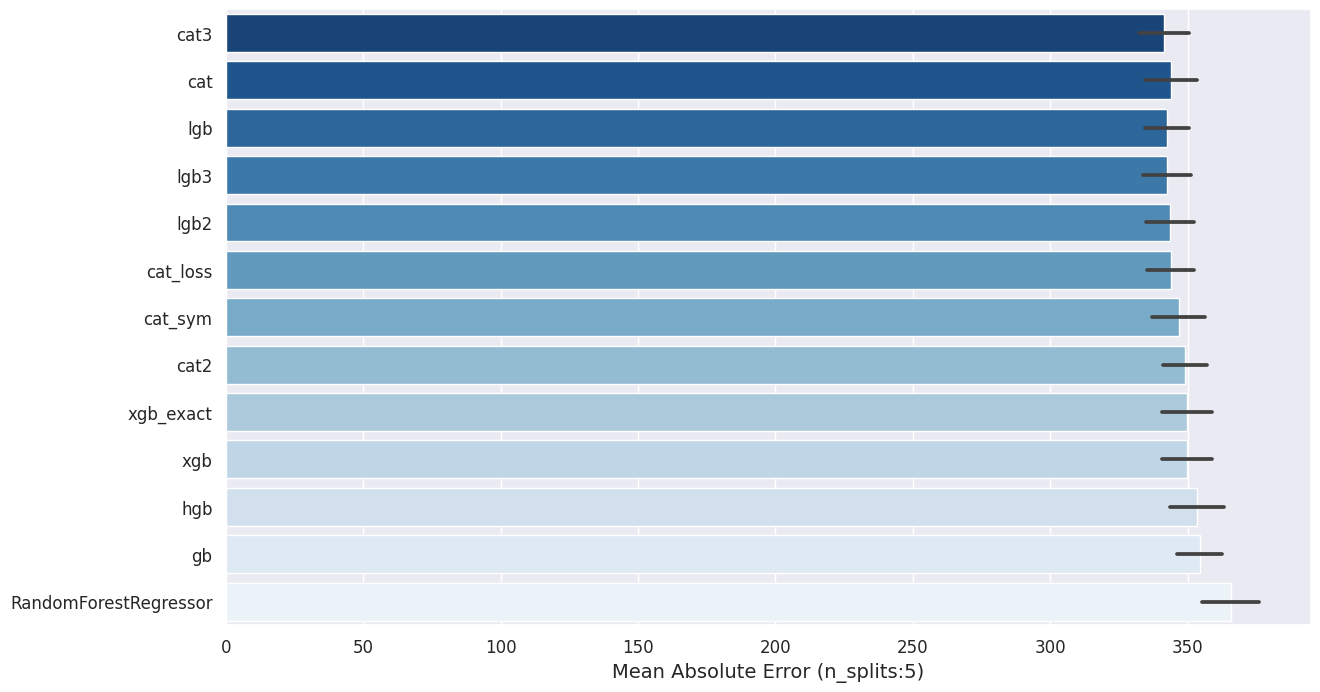

In [117]:
def plot_score_from_dict(score_dict, title='Mean Absolute Error', ascending=True):
    score_df = pd.melt(pd.DataFrame(score_dict))
    score_df = score_df.sort_values('value', ascending=ascending)

    plt.figure(figsize=(14, 8))
    sns.barplot(x='value', y='variable', data=score_df, palette='Blues_r', errorbar='sd')
    plt.xlabel(f'{title}', fontsize=14)
    plt.ylabel('')
    #plt.title(f'{title}', fontsize=18)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, axis='x')
    plt.show()

plot_score_from_dict(score_dict, title=f'Mean Absolute Error (n_splits:{n_splits})')

## Weights

Ensemble MAE score 339.62302 ± 7.97991

--- Model Weights ---
gb: 0.00273 ± 0.00486
hgb: 0.00075 ± 0.00079
xgb: 0.01080 ± 0.00951
xgb_exact: 0.00285 ± 0.00320
lgb: 0.22478 ± 0.38490
lgb2: 0.37159 ± 0.27322
lgb3: 0.36037 ± 0.36785
cat: 0.08211 ± 0.05836
cat2: 0.23235 ± 0.22213
cat3: 0.88587 ± 0.10509
cat_sym: 0.02603 ± 0.05042
cat_loss: 0.02598 ± 0.04952
RandomForestRegressor: 0.10751 ± 0.10955


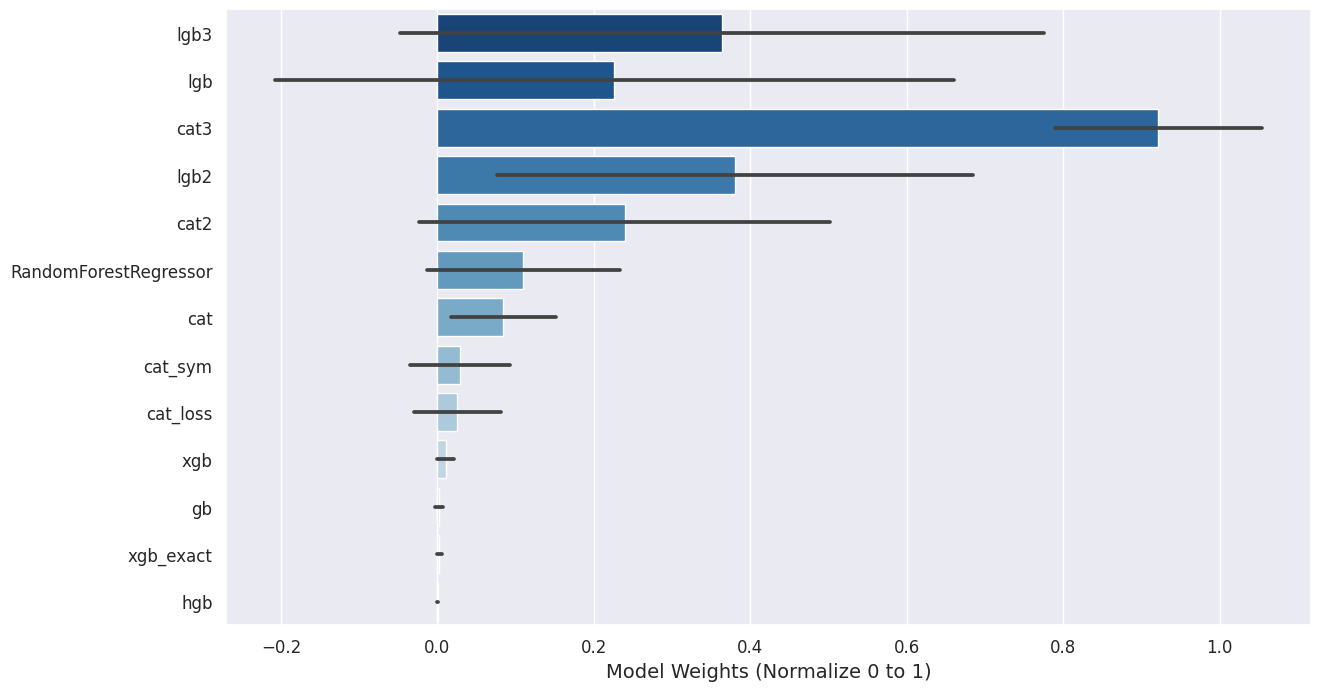

In [118]:
# Calculate the mean LogLoss score of the ensemble
mean_score = np.mean(ensemble_score)
std_score = np.std(ensemble_score)
print(f'Ensemble MAE score {mean_score:.5f} ± {std_score:.5f}')

print('')
# Print the mean and standard deviation of the ensemble weights for each model
print('--- Model Weights ---')
mean_weights = np.mean(weights, axis=0)
std_weights = np.std(weights, axis=0)
for name, mean_weight, std_weight in zip(models.keys(), mean_weights, std_weights):
    print(f'{name}: {mean_weight:.5f} ± {std_weight:.5f}')

# weight_dict = dict(zip(list(score_dict.keys()), np.array(weights).T.tolist()))
# plot_score_from_dict(weight_dict, title='Model Weights', ascending=False)
normalize = [((weight - np.min(weight)) / (np.max(weight) - np.min(weight))).tolist() for weight in weights]
weight_dict = dict(zip(list(score_dict.keys()), np.array(normalize).T.tolist()))
plot_score_from_dict(weight_dict, title='Model Weights (Normalize 0 to 1)', ascending=False)

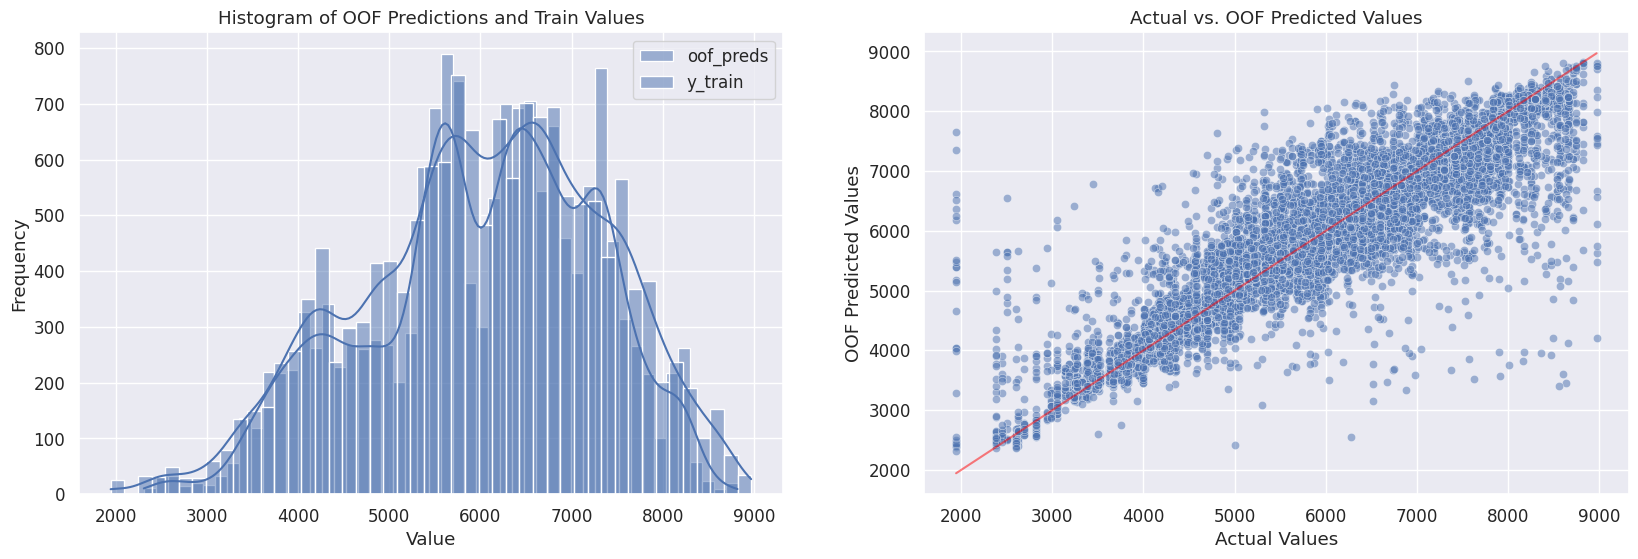

In [119]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
sns.histplot(oof_predss, kde=True, alpha=0.5, label='oof_preds')
sns.histplot(y_train.values, kde=True, alpha=0.5, label='y_train')
plt.title('Histogram of OOF Predictions and Train Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_train.values.reshape(-1), y=oof_predss, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('OOF Predicted Values')
plt.title('Actual vs. OOF Predicted Values')

plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', alpha=0.5)
plt.show()

# Submisssion and Post-Processing

In [120]:
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [121]:
unique_targets = np.unique(y_train)
def mattop_post_process(preds):
     return np.array([min(unique_targets, key = lambda x: abs(x - pred)) for pred in preds])

pred = sample_submission
pred['yield'] = mattop_post_process(test_predss)
pred.to_csv('/drive/My Drive/Colab Notebooks/Kaggle/ML_kaggle_blueberries.csv',index=True)
pred

,yield
id,
15289,4278.76321
15290,5954.51315
15291,7243.22611
15292,4641.00151
15293,3834.57480
...,...
25478,5424.12351
25479,5649.03716
25480,6482.70572


# References

Notebook inspired by:
https://www.kaggle.com/code/tetsutani/ps3e14-eda-various-models-ensemble-baseline/notebook for optimization and blending.
https://www.kaggle.com/competitions/playground-series-s3e14/discussion/407327 for a discussion of postprocessing (cardinality and competition trick).
